### Guided Project: Answering Business Questions using SQL

In this project, we will exploring and answering key business questions using a modified version of a database called [Chinook](https://github.com/lerocha/chinook-database)

This database contains information about a fictional digital music shop, and holds information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers and customer purchases.

These information is contained in eleven tables, and the schema diagram below shows the columns and structure of the database.

#### Import Python Libraries

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#### Connect Sqlite Database

In [2]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

### Exploring the Database
#### Query the database to get a list of all tables and views in the database

In [3]:
def view_chinook():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

view_chinook()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


#### Top 5 Albums 
This is calculated by the number of times a track from that album has been purchased.

In [4]:
top_5 = '''
SELECT 
    ta.album_title album,
    ta.artist_name artist,
    COUNT(*) tracks_purchased
FROM invoice_line i
INNER JOIN
        (
        SELECT 
            t.track_id,
            al.title album_title,
            ar.name artist_name
        FROM artist ar
        INNER JOIN album al ON ar.artist_id = al.artist_id
        INNER JOIN track t ON al.album_id = t.album_id
        ) ta
        ON ta.track_id = i.track_id
GROUP BY 1, 2
ORDER BY 3 DESC LIMIT 5;
'''

run_query(top_5)

,album,artist,tracks_purchased
0,Are You Experienced?,Jimi Hendrix,187
1,Faceless,Godsmack,96
2,Mezmerize,System Of A Down,93
3,Get Born,JET,90
4,The Doors,The Doors,83


#### Summarise Purchases of Each Customer

In [5]:
purchase_cat = '''
SELECT
    c.first_name || ' ' || c.last_name customer_name,
    COUNT(i.invoice_id) number_of_purchases,
    SUM(i.total) total_spent,
    CASE
        WHEN SUM(i.total) < 40 THEN 'small spender'
        WHEN SUM(i.total) > 100 THEN 'big spender'
        ELSE 'regular'
        END
        AS customer_category
FROM customer c
INNER JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY 1
ORDER BY 1;
'''

run_query(purchase_cat).head()

,customer_name,number_of_purchases,total_spent,customer_category
0,Aaron Mitchell,8,70.29,regular
1,Alexandre Rocha,10,69.30,regular
2,Astrid Gruber,9,69.30,regular
3,Bjørn Hansen,9,72.27,regular
4,Camille Bernard,9,79.20,regular


#### Display Summary Data of every Playlist in the database

In [6]:
playlist_summary = '''
WITH 
    track_info AS
        (SELECT
            p.playlist_id,
            p.name playlist_name,
            t.name track_name,
            (t.milliseconds / 1000) length_seconds
        FROM playlist p
        LEFT JOIN playlist_track pt ON pt.playlist_id = p.playlist_id
        LEFT JOIN track t ON t.track_id = pt.track_id
        )
    SELECT
        playlist_id,
        playlist_name,
        COUNT(track_name) number_of_tracks,
        SUM(length_seconds) length_seconds
    FROM track_info
    GROUP BY 1, 2
    ORDER BY 1 ASC
    '''

run_query(playlist_summary)

,playlist_id,playlist_name,number_of_tracks,length_seconds
0,1,Music,3290,876049.0
1,2,Movies,0,NaN
2,3,TV Shows,213,500987.0
3,4,Audiobooks,0,NaN
4,5,90’s Music,1477,397970.0
5,6,Audiobooks,0,NaN
6,7,Movies,0,NaN
7,8,Music,3290,876049.0
8,9,Music Videos,1,294.0
9,10,TV Shows,213,500987.0


####  Find the customer from each country that has spent the most money at our store, ordered alphabetically by country

In [7]:
country_best_customer = '''
WITH 
    customer_country_purchases AS 
        (
            SELECT
                i.customer_id,
                c.country,
                SUM(i.total) total_purchases
            FROM invoice i
            INNER JOIN customer c ON i.customer_id = c.customer_id
            GROUP BY 1
        ),
    country_max_purchase AS
            (
             SELECT
                 country,
                 MAX(total_purchases) max_purchase
             FROM customer_country_purchases
             GROUP BY 1
            ),
    country_best_customer AS
            (
             SELECT
                cmp.country,
                cmp.max_purchase,
                (
                 SELECT ccp.customer_id
                 FROM customer_country_purchases ccp
                 WHERE ccp.country = cmp.country AND cmp.max_purchase = ccp.total_purchases
                ) customer_id
             FROM country_max_purchase cmp
            )
SELECT
    cbc.country country,
    c.first_name || " " || c.last_name customer_name,
    cbc.max_purchase total_purchased
FROM customer c
INNER JOIN country_best_customer cbc ON cbc.customer_id = c.customer_id
ORDER BY 1 ASC
'''

run_query(country_best_customer)

,country,customer_name,total_purchased
0,Argentina,Diego Gutiérrez,39.60
1,Australia,Mark Taylor,81.18
2,Austria,Astrid Gruber,69.30
3,Belgium,Daan Peeters,60.39
4,Brazil,Luís Gonçalves,108.90
5,Canada,François Tremblay,99.99
6,Chile,Luis Rojas,97.02
7,Czech Republic,František Wichterlová,144.54
8,Denmark,Kara Nielsen,37.62
9,Finland,Terhi Hämäläinen,79.20


### CASE 1 - Album Selection for Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name         |Genre  |
|--------------------|-------|
|Regal               |Hip-Hop|
|Red Tone            |Punk   |
|Meteor and the Girls| Pop   |
|Slim Jim Bites      |Blues  |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

#### TASK: Write a query to find out which genres sell the most tracks in the USA, and make a recommendation for the three artists whose albums the store should purchase.

The query should return the most number of tracks in 
     - absolute numbers
     - percentages

In [8]:
album_to_purchase = '''
WITH
    usa_sold_tracks AS 
        (
            SELECT *
            FROM invoice_line il
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            INNER JOIN customer c ON c.customer_id = i.customer_id
            WHERE c.country = 'USA'
        )
SELECT
    g.name Genre,
    COUNT(usa.invoice_line_id)  "Number of Sold Tracks",
    ROUND(CAST (COUNT(usa.invoice_line_id) AS FLOAT) / 
        (SELECT COUNT(*) FROM usa_sold_tracks),2) "Sold Track Percentage"
FROM usa_sold_tracks usa
INNER JOIN track t ON t.track_id = usa.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''

run_query(album_to_purchase)

,Genre,Number of Sold Tracks,Sold Track Percentage
0,Rock,561,0.53
1,Alternative & Punk,130,0.12
2,Metal,124,0.12
3,R&B/Soul,53,0.05
4,Blues,36,0.03
5,Alternative,35,0.03
6,Pop,22,0.02
7,Latin,22,0.02
8,Hip Hop/Rap,20,0.02
9,Jazz,14,0.01


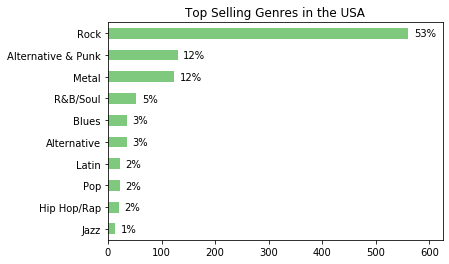

In [9]:
usa_genres_sales = run_query(album_to_purchase)
usa_genres_sales.set_index('Genre', drop=True, inplace=True)
usa_genres_sales.sort_values('Number of Sold Tracks', inplace=True)
usa_genres_sales['Number of Sold Tracks'].plot.barh(
            title = 'Top Selling Genres in the USA',
            xlim = (0,625),
            colormap = plt.cm.Accent
)

plt.ylabel('')

for i, genre in enumerate(list(usa_genres_sales.index)):
    score = usa_genres_sales.loc[genre, "Number of Sold Tracks"]
    label = (usa_genres_sales.loc[genre, "Sold Track Percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the findings, the three artists that the purchase should purchase are
- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

However, it should be noted that these genres only make up 17% of the total sales in the USA. Artists and albums in the Rock genre should be looked out for as this makes up for 53% of the total sales.

### CASE 2 - Analysis of Employees Sales Performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

In [10]:
sales_performance = '''
WITH 
    sales_rep AS
    (
        SELECT 
            c.support_rep_id,
            ROUND(SUM(i.total),2) total
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY 1
    )
SELECT 
    e.first_name || ' ' || e.last_name "Employee",
    e.hire_date "Date Hired",
    s.total "Total Sales (USD)"
FROM employee e
INNER JOIN sales_rep s ON s.support_rep_id = e.employee_id
'''

run_query(sales_performance)

,Employee,Date Hired,Total Sales (USD)
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


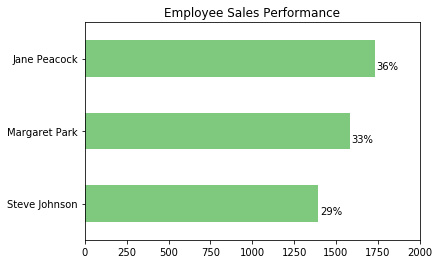

In [11]:
sales_performance = run_query(sales_performance)

sales_performance.set_index('Employee', drop=True, inplace=True)
sales_performance.sort_values('Total Sales (USD)', inplace=True)
sales_performance.plot.barh(
            legend = False,
            xlim = (0,2000),
            title = 'Employee Sales Performance',
            colormap = plt.cm.Accent
)

plt.ylabel('')

for i, employee in enumerate(list(sales_performance.index)):
    score = sales_performance.loc[employee, "Total Sales (USD)"]
    label = (sales_performance.loc[employee, "Total Sales (USD)"]/sum(sales_performance["Total Sales (USD)"]) * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

The difference in total sales between Jane (top sales rep) and Steve (least sales rep) could be attributed to experience and duration in the business, as there is about 6 months difference in their start dates.

### CASE 3 - Analysis of Sales per Country

In [12]:
sales_by_country = '''
WITH country_or_other AS
    (
        SELECT
            CASE
                WHEN (
                      SELECT COUNT(*)
                      FROM customer
                      WHERE country = c.country
                     ) = 1 THEN 'Other'
                ELSE c.country
            END AS country,
            c.customer_id,
            il.*
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
        )
    
SELECT
    Country,
    Customers,
    "Total Sales Value",
    "Customer Lifetime Value",
    "Average Order Value"
FROM (
    SELECT
        country Country,
        COUNT(DISTINCT(customer_id)) Customers,
        SUM(unit_price) "Total Sales Value",
        SUM(unit_price) / COUNT(DISTINCT(customer_id)) "Customer Lifetime Value",
        SUM(unit_price) / COUNT(DISTINCT(invoice_id)) "Average Order Value"
    FROM country_or_other
    GROUP BY 1
    ORDER BY 5 ASC, "Total Sales Value" DESC
);'''

run_query(sales_by_country)

,Country,Customers,Total Sales Value,Customer Lifetime Value,Average Order Value
0,Portugal,2,185.13,92.565000,6.383793
1,Brazil,5,427.68,85.536000,7.011148
2,Canada,8,535.59,66.948750,7.047237
3,Other,15,1094.94,72.996000,7.448571
4,France,5,389.07,77.814000,7.781400
5,USA,13,1040.49,80.037692,7.942672
6,Germany,4,334.62,83.655000,8.161463
7,India,2,183.15,91.575000,8.721429
8,United Kingdom,3,245.52,81.840000,8.768571
9,Czech Republic,2,273.24,136.620000,9.108000


#### Visualizing the Sales by Country

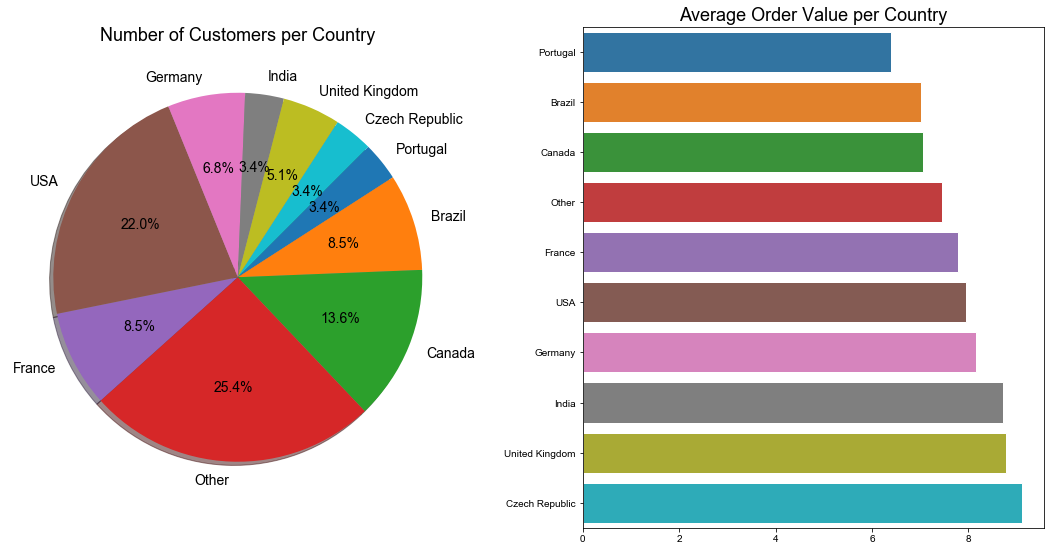

In [13]:
sales_country = run_query(sales_by_country)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
fig.subplots_adjust(hspace=.5, wspace=.3)

# TOP LEFT
labels = sales_country["Country"].tolist()
sizes = sales_country["Customers"].tolist()
ax[0].pie(sizes, counterclock=False, labels=labels, 
          autopct='%1.1f%%', shadow=True, 
          startangle=45,
         textprops={'fontsize': 14})
ax[0].set_title("Number of Customers per Country", fontsize=18)

# TOP RIGHT
sns.set_style("white")
sales_values = sales_country["Average Order Value"].tolist()
sns.barplot(y = labels, x = sales_values, data = sales_country, orient='h', ax = ax[1])
ax[1].set_title("Average Order Value per Country", fontsize=18)
sns.set(font_scale = 1.5)
plt.tight_layout()
plt.show()

#### Observation
The data shows that there are potential opportunities to explore in the following counrtries:
- Czecch Republic
- United Kingdom
- India
- Germany
as customers from these countries tend to spend more on average.These observations are only indicative as they rae based on results from a relatively small sample data. Therefore caution should be taken on how much money is spent on marketing campaigns.

### CASE - Albums vs Individual Tracks Purchase
The goal is to investigate if it is better to buy individual tracks or albums with select tracks from the record companies.

In [14]:
album_or_track_purchase = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(album_or_track_purchase)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


From the summary table, we see that album puchase account for just 18.6% of purchases. Therefore, based on this fact alone, the recommendation will be against purchasing albums with select tracks, as customers tend to purchases individual tracks rather than full or select-track albumns.

### TODO

- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?